In [69]:
import twstock
import pandas as pd
# 導入twstock及pandas模組，pandas模組縮寫為pd

target_stock = '0050'  #股票代號變數
stock = twstock.Stock(target_stock)  #告訴twstock我們要查詢的股票

In [8]:
stock.date[0]

datetime.datetime(2021, 11, 19, 0, 0)

In [70]:
target_price = stock.fetch_from(2021, 12)  #取用2020/05至今每天的交易資料

name_attribute = [
    'Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change',
    'Trascation'
]  #幫收集到的資料設定表頭

df = pd.DataFrame(columns=name_attribute, data=target_price)

In [9]:
print(type(target_price[0]))
print(target_price[0])

<class 'twstock.stock.Data'>
Data(date=datetime.datetime(2021, 12, 1, 0, 0), capacity=4329326, turnover=603377795, open=138.1, high=140.5, low=138.05, close=140.3, change=2.3, transaction=5203)


In [71]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')
#將twstock抓到的清單轉成Data Frame格式的資料表
df
filename = f'./{target_stock}.csv'
#指定Data Frame轉存csv檔案的檔名與路徑

df.to_csv(filename)
#將Data Frame轉存為csv檔案

In [72]:
import pandas as pd
import matplotlib
import mplfinance as mpf
# 導入pandas、matplotlib、mplfinance模組，將mplfinance模組縮寫為mpf
# 這邊要導入matplotlib的原因是因為mplfinance繪圖時需要調用mptplotlib模組

target_stock = '0050' #設定要繪製走勢圖的股票
df = df.set_index(pd.to_datetime(df['Date'], unit='s'))
#df = pd.read_csv(f'./{target_stock}.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置

df.rename(columns={'Turnover':'Volume'}, inplace = True) 
#這裡針對資料表做一下修正，因為交易量(Turnover)在mplfinance中須被改為Volume才能被認出來

mc = mpf.make_marketcolors(up='r',down='g',inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)
#針對線圖的外觀微調，將上漲設定為紅色，下跌設定為綠色，符合台股表示習慣
#接著把自訂的marketcolors放到自訂的style中，而這個改動是基於預設的yahoo外觀

In [73]:
df = df.set_index(pd.to_datetime(df['Date'], unit='s'))
#df = pd.read_csv(f'./{target_stock}.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置

df.rename(columns={'Turnover':'Volume'}, inplace = True) 
#這裡針對資料表做一下修正，因為交易量(Turnover)在mplfinance中須被改為Volume才能被認出來

mc = mpf.make_marketcolors(up='r',down='g',inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)
kwargs = dict(type='candle', mav=(5,20,60), volume=True, figratio=(5,4), figscale=1, title=target_stock, style=s) 
#設定可變參數kwargs，並在變數中填上繪圖時會用到的設定值

mpf.plot(df, **kwargs, savefig='testsave.png')
#選擇df資料表為資料來源，帶入kwargs參數，畫出目標股票的走勢圖

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import tushare as ts
from copy import deepcopy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

In [2]:
class GetData:
    def __init__(self, stockId, savePath) -> None:
        self.stockId = stockId
        self.savePath = savePath
        self.data = None
        self.close_min = None
        self.close_max = None
        
    def get_data(self, predict=False):
        if predict:
            data = pd.read_csv(f'./predictData.csv', parse_dates=True, index_col=1)
            print(data)
            data = data[["Open", "Close", "High", "Low", "Turnover"]]
            data = data.apply(lambda x: (x- min(x)) / (max(x) - min(x)))
            data.to_csv('./predict.csv')
            return data
        else:
            self.data = pd.read_csv(f'./0050.csv', parse_dates=True, index_col=1)
            self.data = self.data[["Open", "Close", "High", "Low", "Turnover"]]
            self.close_min = self.data['Close'].min()
            self.close_max = self.data['Close'].max()
            self.data = self.data.apply(lambda x: (x- min(x)) / (max(x) - min(x)))
            self.data.to_csv(self.savePath)
            return self.data
    
    def process_data(self, n):
        if self.data is None:
            self.get_data()
        feature = [
            self.data.iloc[i: i+n].values.tolist() 
            for i in range(len(self.data) -n + 2)
            if i +n < len(self.data)
        ]
        try:
            label = [
                self.data.Close.values[i + n]
                for i in range(len(self.data) -n + 2)
                if i +n < len(self.data)
            ]
        except:
            label = []
        
        return feature, label
    
    def process_predict_data(self, n, data):
        feature = [
            data.iloc[i: i+n].values.tolist()
            for i in range(len(data) -n + 2)
                if i +n < len(data)
        ]
        return feature

In [3]:
class LSTM(nn.Module):
    def __init__(self, n) -> None:
        super().__init__()
        self.lstmLayer = nn.LSTM(input_size=n, hidden_size=128, batch_first=True)
        self.linearLayer = nn.Linear(in_features=128, out_features=1, bias=True)
        
    def forward(self, x):
        out1, (h_n, h_c) = self.lstmLayer(x)
        a, b, c = h_n.shape
        out2 = self.linearLayer(h_n.reshape(a*b, c))
        return out2

In [4]:
def train_model(Epoch, trainDataLoader, testDataLoader):
    # train model
    bestModel = None
    trainLoss = 0
    testLoss = 0
    bestLoss = 100
    epochCount = 0
    for epoch in range(Epoch):
        totalTrainLoss = 0
        totalTrainNum = 0
        totalTestLoss = 0
        totalTestNum = 0
        
        for x,y in tqdm(trainDataLoader, desc=f'Epoch: {epoch}| Train Loss: {trainLoss}| Test Loss: {testLoss}'):
            numX = len(x)
            y = y.float()
            p = lstm(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            totalTrainLoss += loss.item()
            totalTrainNum += numX
        trainLoss = totalTrainLoss / totalTrainNum
        
        for x,y in testDataLoader:
            numX = len(x)
            y = y.float()
            p = lstm(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            totalTestLoss += loss.item()
            totalTestNum += numX
        testLoss = totalTestLoss / totalTestNum
        
        # early stop
        if bestLoss > testLoss:
            bestLoss = testLoss
            bestModel = deepcopy(lstm)
            epochCount = 0
        else:
            epochCount += 1
            
        if epochCount > earlyStop:
            torch.save(bestModel.state_dict(), 'lstm_.pth')
            break

In [5]:
def test_model(fea: int, testDataLoader_):
    predict = []
    label = []
    lstm_ = LSTM(fea)
    lstm_.load_state_dict(torch.load("lstm_.pth"))
    lstm_.eval()
    totalTestLoss = 0
    totalTestNum = 0
    for x, y in testDataLoader_:
        numX = len(x)
        y = y.float()
        p = lstm_(x)
        loss = loss_func(p, y)
        totalTestLoss += loss.item()
        totalTestNum += numX
        predict.extend(p.data.squeeze(1).tolist())
        label.extend(y.tolist())
    testLoss = totalTestLoss / totalTestNum
    
    return predict, label, testLoss

In [6]:
def predict_model(fea: int, x):
    lstm_ = LSTM(fea)
    lstm_.load_state_dict(torch.load("lstm_.pth"))
    lstm_.eval()
    p = lstm_(x)
    predict.extend(p.data.squeeze(1).tolist())
    
    return p

In [7]:
def plt_img(data, predict):
    plt.plot(range(len(predict)), predict, color='green', label="predicted stock price")
    plt.plot(range(len(data)), data, color='b', label="real stock price")
    for i in range(0, len(predict)-3, 5):
        price = [
            data[i] + predict[j] - predict[i]
            for j in range(i, i+3)
        ]
        plt.plot(range(i, i+3), price, color='r')
    
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close', fontsize=18)
    plt.legend()
    plt.show()

Epoch: 0| Train Loss: 0| Test Loss: 0:   0%|          | 0/25 [00:00<?, ?it/s]/Users/anita/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|██████████| 25/25 [00:00<00:00, 195.50it/s]
/Users/anita/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch: 1| Train Loss: 0.0007369332344969734| Test Loss: 0.0009040617600508165: 100%|██████████| 25/25 [00:00<00:0

228 228


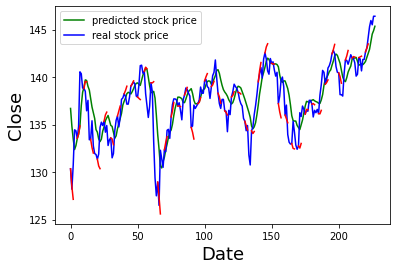

In [8]:
# hyper parameter
daysNum = 5
epoch = 50
fea = 5
batchSize = 20
earlyStop = 5
learningRate = 0.001

# init model
lstm = LSTM(fea)

# data processing
data = GetData(stockId='0050', savePath='./data.csv')
feature, label = data.process_data(daysNum)
xTrain = feature[:500]
yTrain = label[:500]
xTest = feature[500:]
yTest = label[500:]

xTrain = torch.tensor(xTrain)
xTest = torch.tensor(xTest)
yTrain = torch.tensor(yTrain)
yTest = torch.tensor(yTest)

trainData = TensorDataset(xTrain, yTrain)
trainDataLoader = DataLoader(trainData, batchSize)
testData = TensorDataset(xTest, yTest)
testDataLoader = DataLoader(testData, batchSize)

# loss func and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learningRate)
train_model(Epoch=epoch, trainDataLoader=trainDataLoader, testDataLoader=testDataLoader)
p, y, testLoss = test_model(fea=fea, testDataLoader_=testDataLoader)
print(len(p), len(y))

# draw
predict = [element * (data.close_max - data.close_min) + data.close_min for element in p]
label = [element * (data.close_max - data.close_min) + data.close_min for element in y]
plt_img(label, predict)

In [11]:
ppppData = GetData(stockId='000963', savePath='./123.csv')
pppredictData = ppppData.get_data(predict=True)
#pFeature, _ = data.process_data(daysNum)
#pTrain = torch.tensor(pFeature)
pppredictData

            Unnamed: 0  Capacity    Turnover   Open   High    Low  Close  \
Date                                                                       
2019-01-02           0   8532073   636107101  75.85  75.90  73.95  74.05   
2019-01-03           1  13347147   981181870  73.80  74.00  73.25  73.35   
2019-01-04           2  21292465  1540084560  72.80  72.80  72.00  72.20   
2019-01-07           3  14605638  1077319115  73.55  74.05  73.25  73.95   
2019-01-08           4  11006700   811364720  74.15  74.15  73.55  73.65   
2019-01-09           5  11430523   855269355  73.95  75.15  73.95  75.00   
2019-01-10           6   2823283   210937625  74.80  74.90  74.50  74.80   
2019-01-11           7  10362915   782200792  75.30  75.75  75.15  75.50   
2019-01-14           8   5298405   397504723  75.45  75.45  74.75  75.00   
2019-01-15           9  11836450   894286699  75.05  75.80  75.05  75.65   
2019-01-16          10  15342503  1159613447  75.65  75.70  75.35  75.55   
2019-01-17  

,Open,Close,High,Low,Turnover
Date,,,,,
2019-01-02,0.859155,0.430233,0.794872,0.458824,0.319881
2019-01-03,0.281690,0.267442,0.307692,0.294118,0.579503
2019-01-04,0.000000,0.000000,0.000000,0.000000,1.000000
2019-01-07,0.211268,0.406977,0.320513,0.294118,0.651833
2019-01-08,0.380282,0.337209,0.346154,0.364706,0.451739
2019-01-09,0.323944,0.651163,0.602564,0.458824,0.484771
2019-01-10,0.563380,0.604651,0.538462,0.588235,0.000000
2019-01-11,0.704225,0.767442,0.756410,0.741176,0.429797
2019-01-14,0.746479,0.651163,0.679487,0.647059,0.140366


In [12]:
pppFeature = ppppData.process_predict_data(5, pppredictData)
pppTrain = torch.tensor(pppFeature)

In [13]:
pppTrain

tensor([[[0.8592, 0.4302, 0.7949, 0.4588, 0.3199],
         [0.2817, 0.2674, 0.3077, 0.2941, 0.5795],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.2113, 0.4070, 0.3205, 0.2941, 0.6518],
         [0.3803, 0.3372, 0.3462, 0.3647, 0.4517]],

        [[0.2817, 0.2674, 0.3077, 0.2941, 0.5795],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.2113, 0.4070, 0.3205, 0.2941, 0.6518],
         [0.3803, 0.3372, 0.3462, 0.3647, 0.4517],
         [0.3239, 0.6512, 0.6026, 0.4588, 0.4848]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.2113, 0.4070, 0.3205, 0.2941, 0.6518],
         [0.3803, 0.3372, 0.3462, 0.3647, 0.4517],
         [0.3239, 0.6512, 0.6026, 0.4588, 0.4848],
         [0.5634, 0.6047, 0.5385, 0.5882, 0.0000]],

        [[0.2113, 0.4070, 0.3205, 0.2941, 0.6518],
         [0.3803, 0.3372, 0.3462, 0.3647, 0.4517],
         [0.3239, 0.6512, 0.6026, 0.4588, 0.4848],
         [0.5634, 0.6047, 0.5385, 0.5882, 0.0000],
         [0.7042, 0.7674,

In [16]:
gg = lstm.forward(pTrain)
gg = [element * (data.close_max - data.close_min) + data.close_min for element in gg.data.squeeze(1).tolist()]
gg[-10:]

NameError: name 'pTrain' is not defined

In [36]:
float(gg)

146.71409606933594

In [14]:
lstm3 = LSTM(5)
lstm3.load_state_dict(torch.load("lstm_.pth"))
lstm3.eval()

LSTM(
  (lstmLayer): LSTM(5, 128, batch_first=True)
  (linearLayer): Linear(in_features=128, out_features=1, bias=True)
)

In [15]:
vv = lstm3(pppTrain)
v = vv.data.squeeze(1).tolist()
result[element * (data.close_max - data.close_min) + data.close_min for element in v]

[93.27510523796082,
 95.2837736427784,
 101.31260707229376,
 112.54159763753415,
 117.70456803739071,
 122.6790990382433,
 126.45379402041436,
 128.88977579176427,
 130.8462417036295,
 136.29194544553758]

In [20]:
v

[nan, nan, nan, nan, nan]

In [10]:
data.data

,Open,Close,High,Low,Turnover
Date,,,,,
2019-01-02,0.064667,0.070649,0.064178,0.085079,0.107380
2019-01-03,0.037333,0.061657,0.039293,0.076190,0.175821
2019-01-04,0.024000,0.046885,0.023576,0.060317,0.286671
2019-01-07,0.034000,0.069364,0.039948,0.076190,0.194888
2019-01-08,0.042000,0.065511,0.041257,0.080000,0.142140
...,...,...,...,...,...
2021-12-28,0.977333,0.985870,0.973150,0.978413,0.638892
2021-12-29,0.992667,0.994220,0.984283,0.987937,0.639656
2021-12-30,0.999333,0.988439,0.982318,0.991746,0.166736


In [5]:
!pip install imgurpython

Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for imgurpython, since package 'wheel' is not installed.
    Running setup.py install for imgurpython ... done
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [6]:
#取得token，方便日後減少pin使用
#client = ImgurClient(client_id, client_secret, access_token, refresh_token)

from imgurpython import ImgurClient

client_id ='46a3cbeb163bb81'
client_secret = '04e825410c751051e6b548a7d2a1b86b42b449b0'


def get_input(string):
    return input(string)


def authenticate():
    # Get client ID and secret from config.py
    client = ImgurClient(client_id, client_secret)

    # Authorization flow, pin example (see docs for other auth types)
    authorization_url = client.get_auth_url('pin')

    print(f"Go to the following URL: {authorization_url}")

    # Read in the pin, handle Python 2 or 3 here.
    pin = get_input("Enter pin code: ")

    # ... redirect user to `authorization_url`, obtain pin (or code or token) ...
    credentials = client.authorize(pin, 'pin')
    client.set_user_auth(credentials['access_token'], credentials['refresh_token'])

    print("Authentication successful! Here are the details:")
    print(f"   Access token:  {credentials['access_token']}")
    print(f"   Refresh token: {credentials['refresh_token']}")
    auth_tokens = {" Access token": credentials['access_token'],
                   " Refresh token": credentials['refresh_token']}

    return client, auth_tokens


# If you want to run this as a standalone script, so be it!
if __name__ == "__main__":
     client , auth_token = authenticate()
     access_token = auth_token[" Access token"]
     refresh_token = auth_token[" Refresh token"]


Go to the following URL: https://api.imgur.com/oauth2/authorize?client_id=46a3cbeb163bb81&response_type=pin
Authentication successful! Here are the details:
   Access token:  74d37721f55f72efa151a19c6122d2cf9a9ab471
   Refresh token: 6e4b2f4b8f563a68070432b8abd57cd69edc779a


In [74]:
tttData = [
        {
            "Capacity": 7064552,
            "Transaction": 8298,
            "Turnover": 1034974917,
            "Open": 146.0,
            "High": 147.35,
            "Low": 146.0,
            "Close": 146.4,
            "Change": 0.9,
            "Date": "2022-01-03"
        },
        {
            "Capacity": 10122789,
            "Transaction": 10438,
            "Turnover": 1507398153,
            "Open": 147.7,
            "High": 149.6,
            "Low": 147.7,
            "Close": 149.6,
            "Change": 3.2,
            "Date": "2022-01-04"
        },
        {
            "Capacity": 11730618,
            "Transaction": 12614,
            "Turnover": 1755680824,
            "Open": 150.1,
            "High": 150.55,
            "Low": 149.1,
            "Close": 149.3,
            "Change": -0.3,
            "Date": "2022-01-05"
        },
        {
            "Capacity": 9085138,
            "Transaction": 13496,
            "Turnover": 1342084958,
            "Open": 148.3,
            "High": 148.75,
            "Low": 147.0,
            "Close": 147.9,
            "Change": -1.4,
            "Date": "2022-01-06"
        },
        {
            "Capacity": 7435645,
            "Transaction": 12008,
            "Turnover": 1095365963,
            "Open": 148.3,
            "High": 149.0,
            "Low": 146.5,
            "Close": 146.6,
            "Change": -1.3,
            "Date": "2022-01-07"
        }
    ]

In [75]:
name_attribute = [
    'Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change',
    'Trascation'
]  #幫收集到的資料設定表頭
name_attr = [
    "Date", 'Capacity', 'Transaction', 'Turnover', 'Open', "High", "Low", "Close", "Change"
]
tttt = pd.DataFrame(columns=name_attribute, data=tttData)
#tttt = pd.DataFrame(data=tttData)

tttt

,Date,Capacity,Turnover,Open,High,Low,Close,Change,Trascation
0,2022-01-03,7064552,1034974917,146.0,147.35,146.0,146.4,0.9,NaN
1,2022-01-04,10122789,1507398153,147.7,149.60,147.7,149.6,3.2,NaN
2,2022-01-05,11730618,1755680824,150.1,150.55,149.1,149.3,-0.3,NaN
3,2022-01-06,9085138,1342084958,148.3,148.75,147.0,147.9,-1.4,NaN
4,2022-01-07,7435645,1095365963,148.3,149.00,146.5,146.6,-1.3,NaN


In [62]:
print(target_price[0])

Data(date=datetime.datetime(2021, 12, 1, 0, 0), capacity=4329326, turnover=603377795, open=138.1, high=140.5, low=138.05, close=140.3, change=2.3, transaction=5203)


In [78]:
import matplotlib
import mplfinance as mpf
#df = df.set_index(pd.to_datetime(tttt['Date'], unit='s'))
#df = pd.read_csv(f'./{target_stock}.csv', parse_dates=True, index_col=1) #讀取目標股票csv檔的位置
tttt['Date'] = pd.to_datetime(tttt['Date'], format="%Y-%m-%d")
tttt.index = pd.DatetimeIndex(tttt['Date'])
tttt.rename(columns={'Turnover':'Volume'}, inplace = True) 
#這裡針對資料表做一下修正，因為交易量(Turnover)在mplfinance中須被改為Volume才能被認出來

mc = mpf.make_marketcolors(up='r',down='g',inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)
kwargs = dict(type='candle', mav=(5,20,60), volume=True, figratio=(5,4), figscale=1, title="target_stock", style=s) 
#設定可變參數kwargs，並在變數中填上繪圖時會用到的設定值

mpf.plot(tttt, **kwargs, savefig='testsave.png')
#選擇df資料表為資料來源，帶入kwargs參數，畫出目標股票的走勢圖

In [41]:
if match:
    print("yes")

In [42]:
c = 20220106
from datetime import datetime

In [44]:
datetime.strptime(str(c), "%Y%m%d")

datetime.datetime(2022, 1, 6, 0, 0)

In [84]:
# Dijkstra's Algorithm in Python


import sys

# locate list
locate = ['台北', '新北', '桃園', '新竹', '苗栗', '花蓮', '台東']

# Providing the graph
vertices = [[0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 0, 0, 1, 0],
            [1, 1, 0, 1, 1, 0, 0],
            [1, 0, 1, 0, 0, 0, 1],
            [0, 0, 1, 0, 0, 1, 0],
            [0, 1, 0, 0, 1, 0, 1],
            [0, 0, 0, 1, 0, 1, 0]]

edges = [[0, 0, 1, 2, 0, 0, 0],
         [0, 0, 2, 0, 0, 3, 0],
         [1, 2, 0, 1, 3, 0, 0],
         [2, 0, 1, 0, 0, 0, 1],
         [0, 0, 3, 0, 0, 2, 0],
         [0, 3, 0, 0, 2, 0, 1],
         [0, 0, 0, 1, 0, 1, 0]]

# Find which vertex is to be visited next
def to_be_visited():
    global visited_and_distance
    v = -10
    for index in range(num_of_vertices):
        if visited_and_distance[index][0] == 0 \
            and (v < 0 or visited_and_distance[index][1] <=
                 visited_and_distance[v][1]):
            v = index
    return v


num_of_vertices = len(vertices[0])

visited_and_distance = [[0, 0]]
for i in range(num_of_vertices-1):
    visited_and_distance.append([0, sys.maxsize])

for vertex in range(num_of_vertices):

    # Find next vertex to be visited
    to_visit = to_be_visited()
    for neighbor_index in range(num_of_vertices):

        # Updating new distances
        if vertices[to_visit][neighbor_index] == 1 and \
                visited_and_distance[neighbor_index][0] == 0:
            new_distance = visited_and_distance[to_visit][1] \
                + edges[to_visit][neighbor_index]
            if visited_and_distance[neighbor_index][1] > new_distance:
                visited_and_distance[neighbor_index][1] = new_distance
        
        visited_and_distance[to_visit][0] = 1

i = 0

# Printing the distance
for distance in visited_and_distance:
    print(f"從 {locate[0]} to {locate[i]}",
          "的最短路徑:", distance[1])
    i = i + 1

從 台北 to 台北 的最短路徑: 0
從 台北 to 新北 的最短路徑: 3
從 台北 to 桃園 的最短路徑: 1
從 台北 to 新竹 的最短路徑: 2
從 台北 to 苗栗 的最短路徑: 4
從 台北 to 花蓮 的最短路徑: 4
從 台北 to 台東 的最短路徑: 3


In [ ]:
# a, b, c, d, e, f, g
a[0, 0, 1, 1, 0, 0, 0],
b[0, 0, 1, 0, 0, 1, 0],
c[1, 1, 0, 1, 1, 0, 0],
d[1, 0, 1, 0, 0, 0, 1],
e[0, 0, 1, 0, 0, 1, 0],
f[0, 1, 0, 0, 1, 0, 1],
g[0, 0, 0, 1, 0, 1, 0]

edges = [[0, 0, 1, 2, 0, 0, 0],
         [0, 0, 2, 0, 0, 3, 0],
         [1, 2, 0, 1, 3, 0, 0],
         [2, 0, 1, 0, 0, 0, 1],
         [0, 0, 3, 0, 0, 2, 0],
         [0, 3, 0, 0, 2, 0, 1],
         [0, 0, 0, 1, 0, 1, 0]]